# Identify malaria cells using cnn

## What is CNN?
Convolutional neural network - I will create one cnn using keras with tensorflow backend. We will use it to make identify malaria cells. Dataset is from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria. Due to its size I'm going to put it in git ignore file.

In [4]:
import numpy as np
np.random.seed(1000)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [5]:
import keras
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

### Preparing image dataset
Here I am resizing images to 64x64. Parasitized images will have label 0 and uninfected 1

In [6]:
import os
import cv2
from PIL import Image

In [7]:
data_dir = 'cell_images/'
SIZE = 64 
dataset =[]
labels = []

In [8]:
parasitized_images = os.listdir(data_dir + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(data_dir + 'Parasitized/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            labels.append(0)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

In [9]:
uninfected_images = os.listdir(data_dir + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(data_dir + 'Uninfected/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            labels.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

### Displaying images
Let's check 5 random images from each type

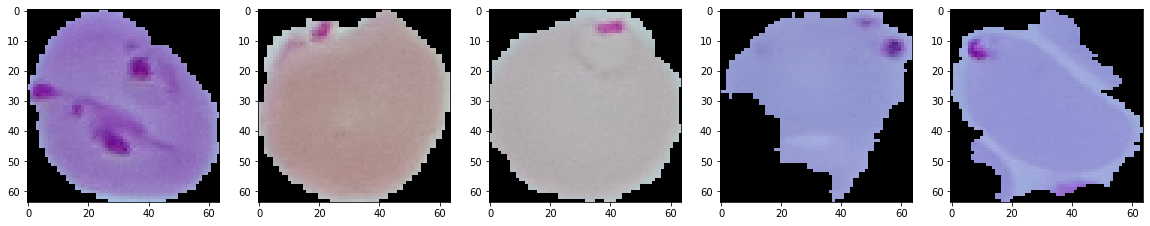

In [10]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(parasitized_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[image_index])

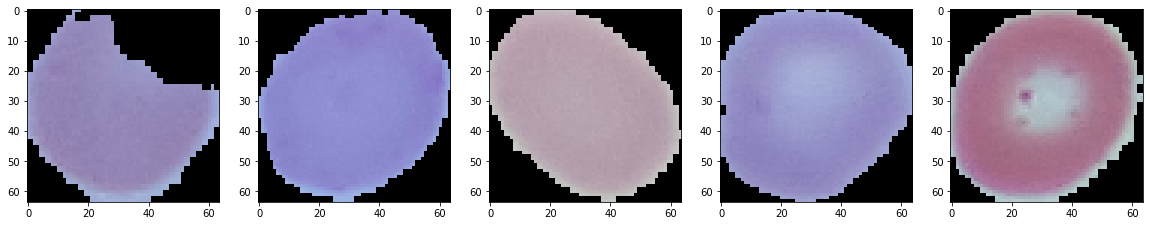

In [11]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(uninfected_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[len(parasitized_images) + image_index])

It looks like everything loaded correctly so we can start with building our cnn

### Creating cnn

In [12]:
my_cnn = Sequential()
my_cnn.add(Convolution2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
my_cnn.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
my_cnn.add(BatchNormalization(axis = -1))
my_cnn.add(Dropout(0.2))
my_cnn.add(Convolution2D(32, (3, 3), activation = 'relu'))
my_cnn.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
my_cnn.add(BatchNormalization(axis = -1))
my_cnn.add(Dropout(0.2))
my_cnn.add(Flatten())
my_cnn.add(Dense(activation = 'relu', units=512))
my_cnn.add(BatchNormalization(axis = -1))
my_cnn.add(Dropout(0.2))
my_cnn.add(Dense(activation = 'relu', units=256))
my_cnn.add(BatchNormalization(axis = -1))
my_cnn.add(Dropout(0.2))
my_cnn.add(Dense(activation = 'sigmoid', units=2))
my_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(my_cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 32)        128       
__________

### Splitting dataset to training and testing sets

In [14]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(labels)), test_size = 0.20, random_state = 0)

### Training cnn

my_cnn.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 64, 
                         verbose = 2, 
                         epochs = 50, 
                         validation_split = 0.1,
                         shuffle = False)

### Loading saved model

In [19]:
from keras.models import load_model
my_cnn = load_model('my_saved_cnn.h5')

### Prediction accuracy

In [20]:
print("Test_Accuracy: {:.2f}%".format(my_cnn.evaluate(np.array(X_test), np.array(y_test))[1]*100))

5512/5512 [==============================] - 29s 5ms/step
Test_Accuracy: 98.24%


So at this moment I have model with 98.24% accuracy. Let's use augmentation to increase this even more